In [2]:

import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import pathlib 
from pdHelper import execQuery
from pdHelper import selectData
from keras.models import load_model
import MizerEval 
args = ['', 'Awsdevsql013', 'Market', 84419752]
proc = 'MizerEvalAction'

def prob(s,m,w):
    x = np.linspace(-2,2,500)
    return (1./(1+np.exp(-w))) * (1./(1+np.exp(8*np.exp(s)*(x - m) )))

def SQLAction(args, proc, action_type, addtl=None):
    """
    Loads input and push output to SQL.

    Parameters:
        args - includes outputid, server and database info.
        proc - action proc name.
        action_type - type of action to be performed in SQL.

    Returns:
        Dataframe with data or nothing depending on the action_type.
    """

    if action_type == 'EvalSuccess':
        query = 'exec ' + proc + ' @ActionType = ' + action_type + ', @OutputId = ' + \
            str(args[3]) + ', @EvalResultJson = ' + "'" + addtl + "'"
        execQuery(query, server = args[1], database = args[2])
        return

    elif action_type == 'EvalFail':
        query = 'exec ' + proc + ' @ActionType = ' + action_type + ', @OutputId = ' + \
            str(args[3]) + ', @ErrMsgTxt = ' + "'" + addtl + "'"
        execQuery(query, server = args[1], database = args[2])
        return

    elif len(args) == 4:
        query = 'exec ' + proc + ' @ActionType = ' + \
            action_type + ', @OutputId = ' + str(args[3])
        data_table = selectData(query, server=args[1], database=args[2])

    elif addtl is not None:
        if len(args) == len(addtl) + 4:
            query = 'exec ' + proc + ' @ActionType = ' + \
                action_type + ', @OutputId = ' + str(args[3])
            i = 4
            for field in addtl:
                query = query + ', @' + field + ' = ' + str(args[i])
                i = i + 1
            data_table = selectData(query, server=args[1], database=args[2])

    return data_table

# MizerEvalOutput 84419752

In [3]:
data=pd.read_csv('time_test.csv')
data_copy = data.copy()
model_path = SQLAction(args, proc, 'GetEvalParams')['ModelPath'][0]+'\\'
# model_path = ''
P = pathlib.Path(model_path)
model = load_model(P/'Model.h5', compile=False)
scaler_path = P/'Scaler.pkl'
with open(scaler_path, 'rb') as f:
    scaler = pickle.load(f)
try:
    features = MizerEval.load_model_features(data, scaler)
except:
    print('error with model features')

missing_names = MizerEval.get_new_feature_names(features.columns, scaler.feature_names_in_, 'SellerName')
missing_names

{'SellerName_firstbank'}

# Missing one seller, first bank

# Why isn't all 0 the right approach? 
## Our model supposes that $ y = f(c, \beta_1 x_1, \beta_2 x_2, \cdots, \beta_p x_p, WX) + \varepsilon $, is the true model. Here $x_1,\dots,x_p$ are the weights,
## $X$ are other factors.
## But if $\beta_1, \dots, \beta_p = 0$ in the case of no seller in the evaluation data, then the result is bias, not average seller behavior.
## Why would all 0's be average seller? It should be omitted variable bias. 
## The supposition is that the other weights absorb the impact of not having a seller weight, but this will not happen,
## there are too many other factors possibly prohibting the changing of those weights, i.e., other observations that also have no seller feature. 
## And if the weights change it will not be mimicking the average seller behavior but rather the behavior of that particular seller that was left out. 

# Example two different sellers with true $W_1 = 10$ and $W_2=-10$ when $x_{i,1}, x_{i,2} = 0$.
## $y1 = f(x_{1,1} \beta_1,x_{1,2} \beta_2,W_1X_{1,1}) +\varepsilon_1 $ 
##  $y1 = f(x_{1,1} \beta_1, x_{1,2} \beta_2, W_2X_{1,2}) +\varepsilon_1 $ 
## How will the gradient update change $ W $ to lower log loss the most? 
## Will it average $W$ to be 0 for these sellers? 
## Or will it accept the bias from $\beta_1,\beta_2$ and keep $W_1$ 10 and $W_2$ -10? 
# Therefore, the result will not be the average seller behavior, it will accept bias in one form or another when these are 0, whichever has a smaller affect on log loss. 

# Method for getting an average seller behavior: 
## 1. Average the weights
## 2. Average the predictions
# Which is correct? Depends on the behavior of the function, 

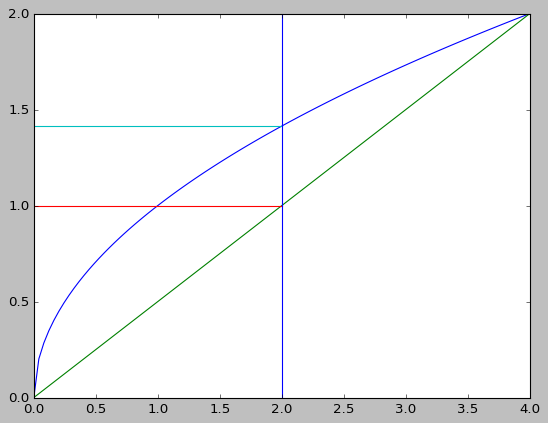

In [9]:
plt.plot(np.linspace(0,4,100), np.sqrt(np.linspace(0,4,100)))
plt.plot(np.linspace(0,4,100), np.linspace(0,2,100))
plt.plot(np.linspace(0,2,100), np.repeat(1,100))
plt.plot(np.linspace(0,2,100), np.repeat(np.sqrt(2),100))
plt.axvline(2)
# plt.style.use('light_background')

# Is it right to take the $E[f(XW)]$ or $f(E[XW])$?
# The purple line is $E[f(XW)]$, the red line is $f(E[XW])$. 

# Method 1: Averaging the weights
## Seller is missing for observation $i$. Average the weights by imputing $1/2$ to each seller feature and averaging the result (taking care to make the proper adjustments for the standardization). 
## $ \hat{y} = \hat{\beta}_1 x_1 + \hat{\beta}_2x_2 $
## The average weight will be $ \frac{ \hat{\beta}_1 +\hat{\beta}_2 }{2}$. 
## Since $x_1 $ and $ x_2$ will be 1 for observations when that seller is present, just use this fact to make the right adjustment. 
## $ \hat{y} = \hat{\beta}_1 \frac{1}{2} + \hat{\beta}_2\frac{1}{2} =  \frac{ \hat{\beta}_1 +\hat{\beta}_2 }{2} $

# Result in test dataset with one missing seller, 

In [5]:
results_weights = MizerEval.run_model2(args,proc)

AttributeError: module 'MizerEval' has no attribute 'run_model2'

In [ ]:
results_weights

,S,M,W,LookId,SellerName,MissingBit
0,-0.094053,0.247238,5.567490,1348752,mortgageresearch,0.0
1,-0.006835,0.187875,5.467845,1348765,mortgageresearch,0.0
2,-0.107592,0.197758,5.421039,1348768,mortgageresearch,0.0
3,0.146090,0.142681,5.452654,1348773,mortgageresearch,0.0
4,0.756412,0.076126,5.676445,1348775,mortgageresearch,0.0
...,...,...,...,...,...,...
995,0.065471,-0.364990,-0.515872,1475083,prosperity,0.0
996,0.560390,-0.322056,-1.801288,1475087,prosperity,0.0
997,1.306396,-0.112746,2.389131,1475102,prosperity,0.0
998,1.478043,-0.189638,1.688059,1475124,prosperity,0.0


In [ ]:
results_weights[results_weights['MissingBit']==1]

,S,M,W,LookId,SellerName,MissingBit
235,0.659255,-0.069122,0.650536,1956391,firstbank,1.0


In [ ]:
results_weights.iloc[:,0:3].mean()

S    0.591847
M   -0.001727
W    3.619793
dtype: float64

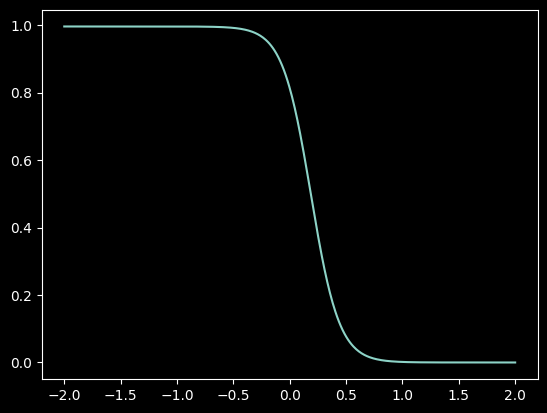

In [ ]:
s = results_weights.iloc[1]['S']
m = results_weights.iloc[1]['M']
w = results_weights.iloc[1]['W']
x = np.linspace(-2,2,500)
plt.plot(x, prob(s,m,w,0))

# Method 2: Averaging the predictions 
# Take the results from the output of layers S,M,W and average these for each missing seller. 


In [ ]:
features.iloc[235]

LookId                    1956391.0
AbaMemberBit                    0.0
CommitPeriodGrp                 7.0
LoanAmt                    356500.0
BaseLoanAmt                356500.0
                            ...    
DayofTheWeek_Friday             0.0
DayofTheWeek_Monday             0.0
DayofTheWeek_Thursday           0.0
DayofTheWeek_Tuesday            0.0
DayofTheWeek_Wednesday          0.0
Name: 235, Length: 630, dtype: float64

# Keep all features the same but make a prediction for each seller and get S,M,W
# $ \hat{y}_1 = w_1 1 + w_2 0 + \dots + w_p 0 + WX + \varepsilon $ 
# $ \hat{y}_2 = w_{1} 0 + w_{2} 1 + \dots + w_{p} 0 + WX + \varepsilon $ 
# $ \hat{y}_3 = w_1 0 + w_2 0 + \dots + w_p 0 + WX + \varepsilon $ 
# $ \vdots $
# $ \hat{y}_n = w_1 0 + w_2 0 + \dots + w_p 1 + WX + \varepsilon $ 
# and take $\frac{1}{n} \sum_i^n \hat{y}$

In [ ]:

results_average = MizerEval.run_model(args,proc)

In [ ]:
results_average[results_average['MissingBit']==1]

,S,M,W,LookId,SellerName,MissingBit
235,0.996013,-0.158998,1.547965,1956391,firstbank,1.0


In [ ]:
results_average[results_average['MissingBit']==1]

,S,M,W,LookId,SellerName,MissingBit
235,0.996013,-0.158998,1.547965,1956391,firstbank,1.0


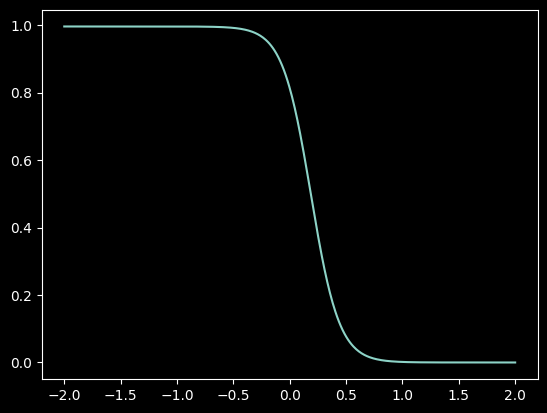

In [ ]:
s = results_average.iloc[1]['S']
m = results_average.iloc[1]['M']
w = results_average.iloc[1]['W']
x = np.linspace(-2,2,500)
plt.plot(x, prob(s,m,w,-0))

In [ ]:
MizerEval.run_model3(args,proc)

-0.006835226